In [ ]:
# Installing Packages
!pip install -q transformers datasets accelerate sentencepiece fsspec[http] fpdf

In [ ]:
# Python imports and device setup
import os
import math
import random
import torch
from transformers import (
    AutoTokenizer,
    BertConfig,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
import matplotlib.pyplot as plt
from fpdf import FPDF

# Device (Colab GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Load wikiText-2 (small) - raw text version
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)

def clean_texts(examples):
    # remove empty lines
    return {"text": [t for t in examples["text"] if t and not t.isspace()]}
# train and validation splits
dataset["train"] = dataset["train"].filter(lambda ex: ex["text"] and not ex["text"].isspace())
dataset["validation"] = dataset["validation"].filter(lambda ex: ex["text"] and not ex["text"].isspace())
print("Train size (lines):", len(dataset["train"]))
print("Valid size (lines):", len(dataset["validation"]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Train size (lines): 23767
Valid size (lines): 2461


In [ ]:
# Use the pure-Python (slow) tokenizer to avoid building the Rust tokenizers package
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)
# ensure tokenizer has mask token
if tokenizer.mask_token is None:
    tokenizer.add_special_tokens({"mask_token": "[MASK]"})
print("Vocab size:", tokenizer.vocab_size)


Vocab size: 30522


In [ ]:
# Tokenize on the fly and group into blocks (for MLM training)
block_size = 128
def tokenize_function(examples):
    return tokenizer(examples["text"], return_special_tokens_mask=True)

tokenized_train = dataset["train"].map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_valid = dataset["validation"].map(tokenize_function, batched=True, remove_columns=["text"])

# Grouping into blocks (concatenate and chunk)
def group_texts(examples):
    # concatenate all input_ids
    concatenated = sum(examples["input_ids"], [])
    total_length = len(concatenated)
    # drop remainder
    total_length = (total_length // block_size) * block_size
    input_ids = [concatenated[i : i + block_size] for i in range(0, total_length, block_size)]
    return {"input_ids": input_ids}

train_dataset = tokenized_train.map(group_texts, batched=True, batch_size=1000, remove_columns=tokenized_train.column_names)
valid_dataset = tokenized_valid.map(group_texts, batched=True, batch_size=1000, remove_columns=tokenized_valid.column_names)

print("Train blocks:", len(train_dataset))
print("Valid blocks:", len(valid_dataset))


Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

Train blocks: 18357
Valid blocks: 1901


In [ ]:
# Data collator that masks tokens dynamically
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
# Small BERT config to keep params low
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=256,          # model dim
    num_hidden_layers=3,      # transformer blocks
    num_attention_heads=4,    # attention heads
    intermediate_size=1024,   # feed-forward inner dim
    max_position_embeddings=512,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

model = BertForMaskedLM(config)
model.to(device)
# print total params
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", count_params(model))


Trainable params: 10411834


Training on: cuda


/tmp/ipython-input-1272622041.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(mb["input_ids"]).to(device)
/tmp/ipython-input-1272622041.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(mb["labels"]).to(device)


Epoch 1 step 200/2295 | loss 8.7364
Epoch 1 step 400/2295 | loss 8.0424
Epoch 1 step 600/2295 | loss 7.7659
Epoch 1 step 800/2295 | loss 7.5976
Epoch 1 step 1000/2295 | loss 7.4762
Epoch 1 step 1200/2295 | loss 7.3851
Epoch 1 step 1400/2295 | loss 7.3147
Epoch 1 step 1600/2295 | loss 7.2523
Epoch 1 step 1800/2295 | loss 7.1993
Epoch 1 step 2000/2295 | loss 7.1564
Epoch 1 step 2200/2295 | loss 7.1171


/tmp/ipython-input-1272622041.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(mb["input_ids"]).to(device)
/tmp/ipython-input-1272622041.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(mb["labels"]).to(device)


Epoch 1 | Train loss=7.1003 | Eval loss=6.7321
Epoch 2 step 200/2295 | loss 6.6695
Epoch 2 step 400/2295 | loss 6.6406
Epoch 2 step 600/2295 | loss 6.6381
Epoch 2 step 800/2295 | loss 6.6305
Epoch 2 step 1000/2295 | loss 6.6217
Epoch 2 step 1200/2295 | loss 6.6144
Epoch 2 step 1400/2295 | loss 6.6108
Epoch 2 step 1600/2295 | loss 6.6013
Epoch 2 step 1800/2295 | loss 6.5933
Epoch 2 step 2000/2295 | loss 6.5881
Epoch 2 step 2200/2295 | loss 6.5830
Epoch 2 | Train loss=6.5782 | Eval loss=6.5407
Epoch 3 step 200/2295 | loss 6.4671
Epoch 3 step 400/2295 | loss 6.4919
Epoch 3 step 600/2295 | loss 6.4813
Epoch 3 step 800/2295 | loss 6.4760
Epoch 3 step 1000/2295 | loss 6.4691
Epoch 3 step 1200/2295 | loss 6.4558
Epoch 3 step 1400/2295 | loss 6.4567
Epoch 3 step 1600/2295 | loss 6.4517
Epoch 3 step 1800/2295 | loss 6.4484
Epoch 3 step 2000/2295 | loss 6.4432
Epoch 3 step 2200/2295 | loss 6.4406
Epoch 3 | Train loss=6.4389 | Eval loss=6.4876
Training completed in: 3.96 minutes
Saved model to: s

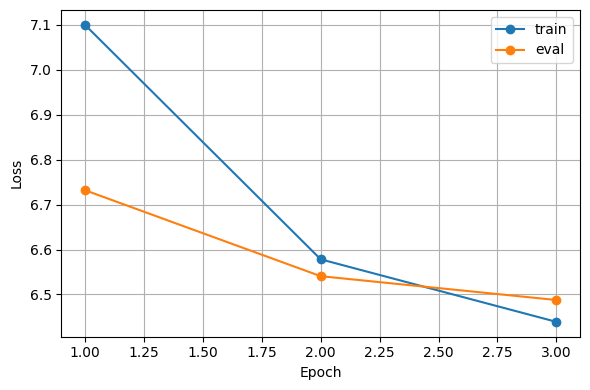

Final eval loss: 6.487579149358413 Perplexity: 656.9311045966517


In [ ]:
# ---------- Pure-PyTorch training loop for MLM ----------
import time, math
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 3
train_batch_size = 8
eval_batch_size = 16
learning_rate = 5e-4
weight_decay = 0.01
max_grad_norm = 1.0

# collate function: pads list of input_id lists into tensors
def collate_fn(batch):
    input_ids = [ex["input_ids"] for ex in batch]
    return tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------- Optimizer ----------
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ---------- Scheduler (simple warmup + decay) ----------
total_steps = len(train_loader) * num_epochs
warmup_steps = max(1, int(0.06 * total_steps))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

train_losses, eval_losses = [], []

print("Training on:", device)
t_start = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for step, batch in enumerate(train_loader, 1):
        batch = {k: v.to(device) for k, v in batch.items()}

        # dynamic masking using the collator
        coll_input = [{"input_ids": ids.tolist()} for ids in batch["input_ids"]]
        mb = data_collator(coll_input)
        input_ids = torch.tensor(mb["input_ids"]).to(device)
        labels = torch.tensor(mb["labels"]).to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        if step % 200 == 0:
            print(f"Epoch {epoch} step {step}/{len(train_loader)} | loss {running_loss/step:.4f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- Evaluation ----------
    model.eval()
    running_eval = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            coll_input = [{"input_ids": ids.tolist()} for ids in batch["input_ids"]]
            mb = data_collator(coll_input)
            input_ids = torch.tensor(mb["input_ids"]).to(device)
            labels = torch.tensor(mb["labels"]).to(device)
            out = model(input_ids=input_ids, labels=labels)
            running_eval += out.loss.item()

    avg_eval_loss = running_eval / len(valid_loader)
    eval_losses.append(avg_eval_loss)

    print(f"Epoch {epoch} | Train loss={avg_train_loss:.4f} | Eval loss={avg_eval_loss:.4f}")

total_mins = (time.time() - t_start) / 60
print("Training completed in:", f"{total_mins:.2f}", "minutes")

# ---------- Save model ----------
save_dir = "saved_model_pytorch"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir + "/tokenizer")
print("Saved model to:", save_dir)

# ---------- Plot losses ----------
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='train')
plt.plot(range(1, len(eval_losses)+1), eval_losses, marker='o', label='eval')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png", dpi=150)
plt.show()

try:
    final_eval = eval_losses[-1]
    print("Final eval loss:", final_eval, "Perplexity:", math.exp(final_eval))
except:
    print("Could not compute perplexity.")


In [ ]:
# ---------- Fine-tune pretrained bert-base-uncased for MLM ----------
import torch, time, math
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pretrained BERT masked LM
from transformers import BertForMaskedLM
pretrained_model_name = "bert-base-uncased"
print("Loading pretrained model:", pretrained_model_name)
model = BertForMaskedLM.from_pretrained(pretrained_model_name)
model.to(device)

# Hyperparams for quick fine-tune
num_epochs = 4
train_batch_size = 8
eval_batch_size = 16
learning_rate = 5e-5
weight_decay = 0.01
max_grad_norm = 1.0

# DataLoaders (reuse previous collate_fn and datasets)
def collate_fn(batch):
    input_ids = [ex["input_ids"] for ex in batch]
    return tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False, collate_fn=collate_fn)

# Optimizer and simple warmup scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = max(1, len(train_loader) * num_epochs)
warmup_steps = max(1, int(0.06 * total_steps))
def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return max(0.0, float(total_steps - step) / float(max(1, total_steps - warmup_steps)))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Train loop (same pattern as before, with dynamic masking via data_collator)
train_losses, eval_losses = [], []
t0 = time.time()
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    for step, batch in enumerate(train_loader, 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        coll_input = [{"input_ids": ids.tolist()} for ids in batch["input_ids"]]
        mb = data_collator(coll_input)   # mb["input_ids"] and mb["labels"] are tensors
        input_ids = mb["input_ids"].to(device)
        labels = mb["labels"].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        running += loss.item()
    avg_train = running / len(train_loader)
    train_losses.append(avg_train)

    # Eval
    model.eval()
    running_eval = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            coll_input = [{"input_ids": ids.tolist()} for ids in batch["input_ids"]]
            mb = data_collator(coll_input)
            input_ids = mb["input_ids"].to(device)
            labels = mb["labels"].to(device)
            out = model(input_ids=input_ids, labels=labels)
            running_eval += out.loss.item()
    avg_eval = running_eval / len(valid_loader)
    eval_losses.append(avg_eval)
    print(f"Epoch {epoch} | train_loss={avg_train:.4f} | eval_loss={avg_eval:.4f}")

total_mins = (time.time() - t0)/60
print("Fine-tuning finished in {:.2f} minutes".format(total_mins))

# Save fine-tuned model (separate folder)
save_dir = "finetuned_bert_base"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir + "/tokenizer")
print("Saved fine-tuned model to:", save_dir)


Device: cuda
Loading pretrained model: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1 | train_loss=2.0672 | eval_loss=1.8659
Epoch 2 | train_loss=1.8795 | eval_loss=1.8203
Epoch 3 | train_loss=1.7709 | eval_loss=1.7676
Epoch 4 | train_loss=1.7013 | eval_loss=1.7584
Fine-tuning finished in 39.75 minutes
Saved fine-tuned model to: finetuned_bert_base


In [ ]:
# Regenerate report.pdf & submission.zip with UTF-8-safe font (DejaVu) or fallback.
import os, math, zipfile, torch
from fpdf import FPDF
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# re-print masked predictions (same as before)
examples = [
    "The capital of [MASK] is Paris.",
    "Zoology is the study of [MASK].",
    "I am my aunt's sister's [MASK]."
]

print("\nTop-5 predictions for masked examples:\n")
topk = 5
for text in examples:
    text_proc = text.replace("[MASK]", tokenizer.mask_token)
    encoded = tokenizer(text_proc, return_tensors="pt")
    input_ids = encoded["input_ids"].to(device)
    mask_token_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)
    with torch.no_grad():
        logits = model(input_ids=input_ids).logits
        for pos in mask_token_index[1].tolist():
            probs = F.softmax(logits[0, pos], dim=-1)
            topk_probs, topk_ids = torch.topk(probs, topk)
            predictions = [tokenizer.decode([idx]).strip() for idx in topk_ids.tolist()]
            print(f"Input: {text}")
            for i, (tok, p) in enumerate(zip(predictions, topk_probs.tolist()), 1):
                print(f"  {i}. {tok}  (score {p:.4f})")
            print()


Top-5 predictions for masked examples:

Input: The capital of [MASK] is Paris.
  1. france  (score 0.9704)
  2. europe  (score 0.0092)
  3. brittany  (score 0.0029)
  4. haiti  (score 0.0023)
  5. africa  (score 0.0010)

Input: Zoology is the study of [MASK].
  1. animals  (score 0.7383)
  2. zoology  (score 0.0981)
  3. invertebrates  (score 0.0421)
  4. birds  (score 0.0180)
  5. dinosaurs  (score 0.0109)

Input: I am my aunt's sister's [MASK].
  1. daughter  (score 0.3065)
  2. son  (score 0.1154)
  3. niece  (score 0.0818)
  4. husband  (score 0.0553)
  5. child  (score 0.0526)



In [ ]:
%%writefile model.py
from transformers import BertConfig, BertForMaskedLM

def build_model():
    """
    Builds the same small-from-scratch model used in the notebook.
    """
    config = BertConfig(
        vocab_size=30522,      # bert-base-uncased vocab
        hidden_size=256,
        num_hidden_layers=3,
        num_attention_heads=4,
        intermediate_size=1024,
        max_position_embeddings=512,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )
    return BertForMaskedLM(config)

if __name__ == "__main__":
    model = build_model()
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable parameters:", params)


Writing model.py


In [ ]:
%%writefile train.py
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from model import build_model

# ---------------- CONFIG ----------------
BLOCK_SIZE = 128
TRAIN_BATCH = 8
EVAL_BATCH = 16
NUM_EPOCHS = 3
LR = 5e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATASET ----------------
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset["train"] = dataset["train"].filter(lambda x: x["text"] and not x["text"].isspace())
dataset["validation"] = dataset["validation"].filter(lambda x: x["text"] and not x["text"].isspace())

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

def tokenize_fn(e):
    return tokenizer(e["text"], return_special_tokens_mask=True)

tokenized_train = dataset["train"].map(tokenize_fn, batched=True, remove_columns=["text"])
tokenized_valid = dataset["validation"].map(tokenize_fn, batched=True, remove_columns=["text"])

def group_texts(examples):
    concatenated = sum(examples["input_ids"], [])
    total_len = (len(concatenated) // BLOCK_SIZE) * BLOCK_SIZE
    chunks = [concatenated[i:i+BLOCK_SIZE] for i in range(0, total_len, BLOCK_SIZE)]
    return {"input_ids": chunks}

train_dataset = tokenized_train.map(group_texts, batched=True, remove_columns=tokenized_train.column_names)
valid_dataset = tokenized_valid.map(group_texts, batched=True, remove_columns=tokenized_valid.column_names)

def collate_fn(batch):
    ids = [x["input_ids"] for x in batch]
    return tokenizer.pad({"input_ids": ids}, return_tensors="pt")

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=EVAL_BATCH, shuffle=False, collate_fn=collate_fn)

# ---------------- MODEL ----------------
model = build_model()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = max(1, len(train_loader) * NUM_EPOCHS)
warmup_steps = int(0.06 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    return max(0.0, (total_steps - step) / (total_steps - warmup_steps))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ---------------- TRAINING ----------------
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        coll_batch = [{"input_ids": b.tolist()} for b in batch["input_ids"]]
        mb = data_collator(coll_batch)

        input_ids = mb["input_ids"].to(device)
        labels = mb["labels"].to(device)

        out = model(input_ids=input_ids, labels=labels)
        loss = out.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"  Train Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            coll_batch = [{"input_ids": b.tolist()} for b in batch["input_ids"]]
            mb = data_collator(coll_batch)
            ids = mb["input_ids"].to(device)
            labels = mb["labels"].to(device)
            out = model(ids, labels=labels)
            eval_loss += out.loss.item()

    print(f"  Eval Loss: {eval_loss/len(valid_loader):.4f}")

# ---------------- SAVE ----------------
model.save_pretrained("saved_model_pytorch")
tokenizer.save_pretrained("saved_model_pytorch/tokenizer")

print("Training complete. Model saved.")


Writing train.py


In [ ]:
!ls -l

total 64
drwxr-xr-x 3 root root  4096 Nov 13 10:06 finetuned_bert_base
-rw-r--r-- 1 root root 41585 Nov 13 09:25 loss_plot.png
-rw-r--r-- 1 root root   679 Nov 13 12:31 model.py
drwxr-xr-x 1 root root  4096 Nov 11 14:29 sample_data
drwxr-xr-x 3 root root  4096 Nov 13 09:25 saved_model_pytorch
-rw-r--r-- 1 root root  3990 Nov 13 12:32 train.py


In [ ]:
from google.colab import files
files.download("model.py")
files.download("train.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>